In [1]:
# tutorial https://blog.socialcops.com/engineering/machine-learning-python/

import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske

#can't use tensorflow as described in the last part of the tutorial,
#because skflow package has been removed; try "learn":

import tensorflow as tf
#from tensorflow.contrib import skflow
import tensorflow.contrib.learn.python.learn as learn

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read the spreadsheet file into a Pandas dataframe
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [3]:
# .head() shows first 5 rows
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
#show chance of survival for a passenger (it's 38%)
titanic_df['survived'].mean()

0.3819709702062643

In [5]:
#group passengers by class and show average survival changes for each class
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


In [6]:
#group by a list of two parameters and assign it to "class_sex_grouping"
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

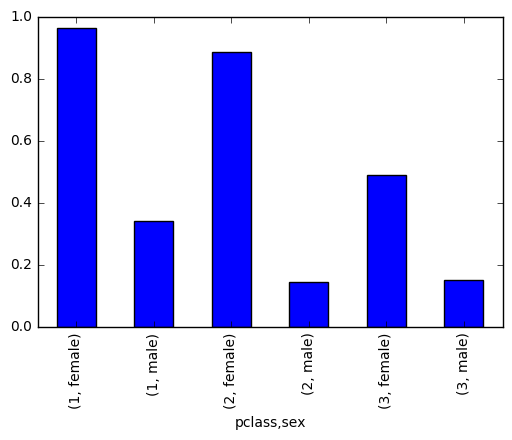

In [7]:
class_sex_grouping['survived'].plot.bar()

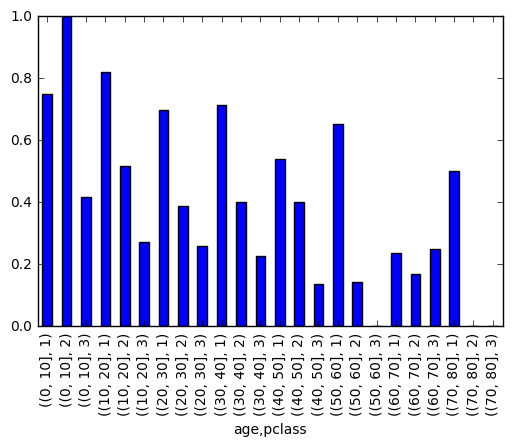

In [8]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby([group_by_age, 'pclass']).mean()
age_grouping['survived'].plot.bar()

In [9]:
# preparing data for machine learning

# first: see which columns have missing values
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [10]:
# drop 3 columns
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)

In [11]:
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")

In [12]:
# drop lines without age
titanic_df = titanic_df.dropna()

In [13]:
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [14]:
# function: format remaining data in a way that the machine learning algorithms will accept
# i.e. male and female become 0 and 1
# drop name, ticket and home.dest because we can't break them down to 0 and 1
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [15]:
# use the function defined above
processed_df = preprocess_titanic_df(titanic_df)

In [16]:
# separate data set into 2 arrays: X with everything but survived, Y only with survived
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [17]:
# divide X and Y in a training set (80%) and in a test group (20%)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [18]:
# make an untrained decision tree classifier named clf_dt,
# that examines one variable after the other

# our tree splits max. 10 times beginning with the most important
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [19]:
# create the tree with our trainig set
clf_dt.fit (X_train, y_train)

# test the tree and see, how accurate it is
clf_dt.score (X_test, y_test)

0.77033492822966509

In [20]:
# Problem: depending on the choosen text data the results vary
# Solution: a shuffle validator that generates 20 unique permutations of the 20/80 split

shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [21]:
test_classifier(clf_dt)

Accuracy: 0.7734 (+/- 0.02)


In [22]:
# next try: the “Random Forest” classification algorithm
# generates several decision trees and returns the most returnd prediction

clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7833 (+/- 0.02)


In [23]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8201 (+/- 0.02)


In [24]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.8055 (+/- 0.02)


In [30]:
# Deep Neural Network (DNN)

# DNNs don't just pass data between nodes, but between layers of nodes
# are able to find patterns in unstructured data
# TensorFlow = open source libary for programing neural networks
# Problem: skflow isn't working anymore 

In [31]:
tf_clf_dnn = skflow.TensorFlowDNNClassifier(hidden_units=[20, 40, 20], n_classes=2, batch_size=256, steps=1000, learning_rate=0.05)
tf_clf_dnn.fit(X_train, y_train)
tf_clf_dnn.score(X_test, y_test)

NameError: name 'skflow' is not defined

In [32]:
def custom_model(X, y):
    layers = skflow.ops.dnn(X, [20, 40, 20], tf.tanh)
    return skflow.models.logistic_regression(layers, y)

In [33]:
tf_clf_c = skflow.TensorFlowEstimator(model_fn=custom_model, n_classes=2, batch_size=256, steps=1000, learning_rate=0.05)
tf_clf_c.fit(X_train, y_train)
metrics.accuracy_score(y_test, tf_clf_c.predict(X_test))

NameError: name 'skflow' is not defined